#Trabajo Práctico Final Visión por Computadora

Julián Gerónimo García

Noviembre 2024

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura


##Objeto

El presente trabajo tiene por objeto...

##Pendientes

Mejorar la aumentación de las clases

##Referencias

https://gentle-cress-e61.notion.site/Unidad-2-Modelos-de-visi-n-y-aplicaciones-c7cb2ad5875a494da1f25fd88af5c6f4

https://gentle-cress-e61.notion.site/Unidad-3-Entrenamiento-de-modelos-de-visi-n-a7783d82189744c5ac4fee17d79c9a10

https://gentle-cress-e61.notion.site/Unidad-4-Procesamiento-de-video-en-tiempo-real-4ab4df68fa5a46bd84cbea0e6da24028

https://gentle-cress-e61.notion.site/Unidad-5-Modelos-generativos-c9d69586b7694c80aefa9c6afcebd9e2

https://gentle-cress-e61.notion.site/Unidad-6-Reconocimiento-y-Comprensi-n-de-Texto-8c6b0ed423184e5da9e3eb57e4450b31

https://docs.ultralytics.com/es/datasets/pose/dog-pose/

https://docs.google.com/document/d/1_HHoDjIp145Gve29GJv1qq718AONe0WtbAs9Xsm-Gss/edit?tab=t.0#heading=h.pd9bv9seyx41

##Setup

In [1]:
!pip install tensorflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 36.5 MB/s eta 0:00:00


In [2]:
from collections import Counter
from collections import defaultdict
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import display, clear_output
import ipywidgets as widgets
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import requests
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import torch
from ultralytics import YOLO
import yaml
import zipfile

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
REPO_NAME = "CV-TUIA-Garcia"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/juliangg17/CV-TUIA-Garcia.git
  os.chdir(REPO_NAME)

Cloning into 'CV-TUIA-Garcia'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 16.08 MiB | 9.50 MiB/s, done.
Resolving deltas: 100% (16/16), done.


##Funciones

###Funciones para Evaluación del modelo

In [5]:
def plot_training_validation_loss(data, title='Training and Validation Loss'):
    """
    Función para graficar las pérdidas de entrenamiento y validación.

    Parameters:
    - data (pd.DataFrame): DataFrame que contiene las columnas de pérdida.
    - title (str): Título del gráfico. Default: 'Training and Validation Loss'.
    """
    plt.figure(figsize=(12, 6))

    # Graficar las pérdidas de entrenamiento
    if 'train/box_loss' in data.columns:
        plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss (Train)', color='blue')
    if 'train/pose_loss' in data.columns:
        plt.plot(data['epoch'], data['train/pose_loss'], label='Pose Loss (Train)', color='green')

    # Graficar las pérdidas de validación
    if 'val/box_loss' in data.columns:
        plt.plot(data['epoch'], data['val/box_loss'], label='Box Loss (Val)', color='red')
    if 'val/pose_loss' in data.columns:
        plt.plot(data['epoch'], data['val/pose_loss'], label='Pose Loss (Val)', color='orange')

    # Configuración del gráfico
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
def plot_map_metrics(data, title='Metrics (mAP) During Training'):
    """
    Función para graficar las métricas mAP50 y mAP50-95 durante el entrenamiento.

    Parameters:
    - data (pd.DataFrame): DataFrame que contiene las columnas 'metrics/mAP50(B)' y 'metrics/mAP50-95(B)'.
    - title (str): Título del gráfico. Por defecto: 'Metrics (mAP) During Training'.
    """
    plt.figure(figsize=(12, 6))

    # Graficar las métricas mAP50 y mAP50-95
    if 'metrics/mAP50(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/mAP50(B)'], label='mAP@50 (B)', color='purple')
    if 'metrics/mAP50-95(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/mAP50-95(B)'], label='mAP@50-95 (B)', color='brown')

    # Configurar el gráfico
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def plot_precision_recall(data, title='Precision and Recall During Training'):
    """
    Función para graficar la precisión y recall durante el entrenamiento.

    Parameters:
    - data (pd.DataFrame): DataFrame que contiene las columnas 'metrics/precision(B)' y 'metrics/recall(B)'.
    - title (str): Título del gráfico. Por defecto: 'Precision and Recall During Training'.
    """
    plt.figure(figsize=(12, 6))

    # Graficar precisión y recall
    if 'metrics/precision(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/precision(B)'], label='Precision (B)', color='blue')
    if 'metrics/recall(B)' in data.columns:
        plt.plot(data['epoch'], data['metrics/recall(B)'], label='Recall (B)', color='green')

    # Configurar el gráfico
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
def load_latest_training_results(base_dir="runs/pose/"):
    """
    Encuentra la carpeta más reciente en el directorio base y carga el archivo results.csv.

    Args:
        base_dir (str): Directorio donde se encuentran los resultados de entrenamiento.

    Returns:
        pd.DataFrame: DataFrame con los resultados del entrenamiento.
        str: Ruta de la carpeta del último entrenamiento.
    """
    # Obtener la lista de carpetas en el directorio base
    subdirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Ordenar las carpetas por fecha de modificación (más reciente primero)
    subdirs = sorted(subdirs, key=os.path.getmtime, reverse=True)

    # Tomar la carpeta más reciente
    latest_dir = subdirs[0] if subdirs else None
    if latest_dir:
        results_path = os.path.join(latest_dir, "results.csv")
        if os.path.exists(results_path):
            print(f"Cargando resultados desde: {results_path}")
            return pd.read_csv(results_path), latest_dir
        else:
            raise FileNotFoundError(f"No se encontró el archivo results.csv en {latest_dir}")
    else:
        raise FileNotFoundError("No se encontraron carpetas en el directorio base.")

###Funciones para Inferencia

In [8]:
def predict_random_image(model, images_path):
    """
    Selecciona una imagen aleatoria de la carpeta, realiza una predicción utilizando el modelo proporcionado,
    dibuja los keypoints y conecta los puntos especificados por pares definidos dentro de la función.
    Además, coloca un número pequeño junto a cada keypoint.

    Argumentos:
        model: Modelo YOLO cargado previamente.
        images_path: Ruta de la carpeta que contiene las imágenes.
    """
    # Verificar si la ruta existe
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"La ruta especificada no existe: {images_path}")

    # Listar todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        raise FileNotFoundError(f"No se encontraron imágenes en la ruta: {images_path}")

    # Seleccionar una imagen aleatoria
    random_image = random.choice(image_files)
    random_image_path = os.path.join(images_path, random_image)

    # Cargar la imagen seleccionada
    image = cv2.imread(random_image_path)

    # Realizar la predicción
    results = model(image)

    # Dibujar los resultados en la imagen
    annotated_image = results[0].plot()

    # Obtener keypoints de la predicción
    keypoints = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        # Extraer las coordenadas (x, y) ignorando el tercer valor (confianza)
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            keypoints.append((float(row[0]), float(row[1])))  # Solo (x, y)
    else:
        print("No se encontraron keypoints en los resultados.")

    # Dibujar los keypoints con números junto a ellos
    for i, (x, y) in enumerate(keypoints):
        if (x, y) != (0.0, 0.0):  # Dibujar solo keypoints válidos
            # Dibujar el punto
            cv2.circle(annotated_image, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)
            # Dibujar el número pequeño junto al punto
            cv2.putText(
                annotated_image,
                str(i),  # Número del keypoint
                (int(x) + 5, int(y) - 5),  # Posición del texto
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,  # Tamaño de la fuente
                (255, 255, 255),  # Color del texto
                1,  # Grosor del texto
                cv2.LINE_AA
            )

    # Definir los pares de puntos a conectar dentro de la función
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (15, 19), (15, 17), (16, 17), (17, 18), (16, 20)]

    # Dibujar líneas entre los puntos especificados en pairs_to_connect
    for pair in pairs_to_connect:
        idx1, idx2 = pair  # Desempaquetar el par de índices
        if idx1 <= len(keypoints) and idx2 <= len(keypoints):  # Verificar que los índices sean válidos
            x1, y1 = keypoints[idx1 - 1]
            x2, y2 = keypoints[idx2 - 1]
            # Verificar que ninguno de los puntos tenga coordenadas (0, 0)
            if (x1, y1) != (0.0, 0.0) and (x2, y2) != (0.0, 0.0):
                pt1 = (int(x1), int(y1))
                pt2 = (int(x2), int(y2))
                cv2.line(annotated_image, pt1, pt2, color=(0, 255, 0), thickness=2)  # Línea verde

    # Mostrar la imagen anotada con las líneas
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Ocultar los ejes
    plt.show()

    # Mostrar los keypoints debajo de la imagen
    if keypoints:
        print("Keypoints detectados (x, y):")
        for i, (x, y) in enumerate(keypoints):
            print(f"{i}: (x: {x:.2f}, y: {y:.2f})")

###Funciones para etiquetado

In [9]:
# Función para etiquetar una imagen
def label_current_image():
    global current_index

    # Si no hay más imágenes, finalizar
    if current_index >= len(image_files):
        clear_output()
        print("¡Todas las imágenes han sido etiquetadas!")
        print(f"Total de imágenes etiquetadas: {len(output_labels)}")
        # Guardar las etiquetas al finalizar
        with open('output_labels.json', 'w') as f:
            json.dump(output_labels, f)
        return

    # Mostrar imagen actual
    img_name = image_files[current_index]
    img_path = os.path.join(images_path, img_name)
    clear_output()  # Limpiar la salida para mostrar solo la imagen actual
    print(f"Imágenes etiquetadas: {len(output_labels)} / {len(image_files)}")  # Contador
    display(Image.open(img_path))  # Mostrar la imagen

    # Selector de etiquetas
    label = widgets.RadioButtons(
        options=['Parado', 'Sentado', 'Tumbado', 'Otro'],  # Opciones de etiqueta
        description='Etiqueta:',
        disabled=False
    )
    display(label)

    # Botón para guardar la etiqueta
    button = widgets.Button(description="Guardar Etiqueta")
    display(button)

    # Función para guardar la etiqueta y avanzar a la siguiente imagen
    def save_label(b):
        global current_index
        output_labels[img_name] = label.value
        print(f"Etiqueta '{label.value}' guardada para {img_name}")
        current_index += 1  # Avanzar al siguiente índice
        label_current_image()  # Mostrar la siguiente imagen

    button.on_click(save_label)

In [10]:
def label_current_image_with_keypoints(model, images_path):
    global current_index

    # Si no hay más imágenes, finalizar
    if current_index >= len(image_files):
        clear_output()
        print("¡Todas las imágenes han sido etiquetadas!")
        print(f"Total de imágenes etiquetadas: {len(output_labels)}")
        # Guardar las etiquetas al finalizar
        with open('output_labels.json', 'w') as f:
            json.dump(output_labels, f)
        return

    # Mostrar imagen actual
    img_name = image_files[current_index]
    img_path = os.path.join(images_path, img_name)
    clear_output()  # Limpiar la salida para mostrar solo la imagen actual
    print(f"Imágenes etiquetadas: {len(output_labels)} / {len(image_files)}")  # Contador

    # Cargar la imagen actual
    image = cv2.imread(img_path)

    # Realizar la predicción
    results = model(image)

    # Dibujar los resultados en la imagen
    annotated_image = results[0].plot()

    # Obtener keypoints de la predicción
    keypoints = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        # Extraer las coordenadas (x, y) ignorando el tercer valor (confianza)
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            keypoints.append((float(row[0]), float(row[1])))  # Solo (x, y)

    # Definir los pares de puntos a conectar
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (15, 19), (15, 17), (16, 17), (17, 18), (16, 20)]

    # Dibujar líneas entre los puntos especificados en pairs_to_connect
    for pair in pairs_to_connect:
        idx1, idx2 = pair  # Desempaquetar el par de índices
        if idx1 <= len(keypoints) and idx2 <= len(keypoints):  # Verificar que los índices sean válidos
            x1, y1 = keypoints[idx1 - 1]
            x2, y2 = keypoints[idx2 - 1]
            # Verificar que ninguno de los puntos tenga coordenadas (0, 0)
            if (x1, y1) != (0.0, 0.0) and (x2, y2) != (0.0, 0.0):
                pt1 = (int(x1), int(y1))  # Convertir a entero
                pt2 = (int(x2), int(y2))
                cv2.line(annotated_image, pt1, pt2, color=(0, 255, 0), thickness=2)  # Línea verde

    # Mostrar la imagen anotada con los keypoints
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Ocultar los ejes
    plt.show()

    # Selector de etiquetas
    label = widgets.RadioButtons(
        options=['Parado', 'Sentado', 'Tumbado', 'Otro'],  # Opciones de etiqueta
        description='Etiqueta:',
        disabled=False
    )
    display(label)

    # Botón para guardar la etiqueta
    button = widgets.Button(description="Guardar Etiqueta")
    display(button)

    # Función para guardar la etiqueta y avanzar a la siguiente imagen
    def save_label(b):
        global current_index
        output_labels[img_name] = label.value
        print(f"Etiqueta '{label.value}' guardada para {img_name}")
        current_index += 1  # Avanzar al siguiente índice
        label_current_image_with_keypoints(model, images_path)  # Mostrar la siguiente imagen

    button.on_click(save_label)

In [11]:
# Función para procesar y reetiquetar imágenes con keypoints y líneas
def relabel_image_with_keypoints(target_class, json_path, images_path, model):
    # Cargar etiquetas desde el archivo JSON
    with open(json_path, "r") as f:
        labels = json.load(f)

    # Filtrar imágenes etiquetadas con la clase específica
    image_files = [img_name for img_name, label in labels.items() if label == target_class]
    current_index = 0  # Índice inicial
    global output_labels  # Asegurarse de que output_labels sea global
    output_labels = labels.copy()  # Hacer una copia de las etiquetas originales

    # Si no hay imágenes para procesar, finalizar
    if len(image_files) == 0:
        clear_output()
        print(f"No se encontraron imágenes etiquetadas como '{target_class}'.")
        return

    # Función para procesar cada imagen
    def process_image():
        nonlocal current_index  # Para modificar la variable dentro de la función interna

        # Si no hay más imágenes, finalizar
        if current_index >= len(image_files):
            clear_output()
            print("¡Todas las imágenes de la clase seleccionada han sido etiquetadas!")
            print(f"Total de imágenes etiquetadas: {len(output_labels)}")
            # Guardar las etiquetas al finalizar
            with open(json_path, "w") as f:
                json.dump(output_labels, f, indent=4)
            return

        # Mostrar imagen actual
        img_name = image_files[current_index]
        img_path = os.path.join(images_path, img_name)
        clear_output()  # Limpiar la salida para mostrar solo la imagen actual
        print(f"Imágenes etiquetadas: {current_index + 1} / {len(image_files)}")  # Contador

        # Cargar la imagen actual
        image = cv2.imread(img_path)
        if image is None:
            print(f"No se pudo cargar la imagen: {img_name}")
            current_index += 1
            process_image()
            return

        # Realizar la predicción de keypoints
        results = model(image)

        # Dibujar los resultados en la imagen
        annotated_image = results[0].plot()

        # Obtener keypoints de la predicción
        keypoints = []
        if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
            # Extraer las coordenadas (x, y) ignorando el tercer valor (confianza)
            keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
            for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
                keypoints.append((float(row[0]), float(row[1])))

        # Definir los pares de puntos a conectar
        pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (15, 19), (15, 17), (16, 17), (17, 18), (16, 20)]

        # Dibujar líneas entre los puntos especificados en pairs_to_connect
        for pair in pairs_to_connect:
            idx1, idx2 = pair  # Desempaquetar el par de índices
            if idx1 <= len(keypoints) and idx2 <= len(keypoints):  # Verificar que los índices sean válidos
                x1, y1 = keypoints[idx1 - 1]
                x2, y2 = keypoints[idx2 - 1]
                # Verificar que ninguno de los puntos tenga coordenadas (0, 0)
                if (x1, y1) != (0.0, 0.0) and (x2, y2) != (0.0, 0.0):
                    pt1 = (int(x1), int(y1))  # Convertir a entero
                    pt2 = (int(x2), int(y2))
                    cv2.line(annotated_image, pt1, pt2, color=(0, 255, 0), thickness=2)  # Línea verde

        # Mostrar la imagen anotada con los keypoints
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Ocultar los ejes
        plt.title(f"Etiqueta actual: {output_labels[img_name]}")
        plt.show()

        # Selector de etiquetas
        label = widgets.RadioButtons(
            options=['Parado', 'Sentado', 'Tumbado', 'Otro'],  # Opciones de etiqueta
            value=output_labels[img_name],  # Etiqueta actual como valor predeterminado
            description='Etiqueta:',
            disabled=False
        )
        display(label)

        # Botón para guardar la etiqueta
        button = widgets.Button(description="Guardar Etiqueta")
        display(button)

        # Función para guardar la etiqueta y avanzar a la siguiente imagen
        def save_label(b):
            nonlocal current_index
            previous_label = output_labels[img_name]  # Obtener la etiqueta anterior
            new_label = label.value  # Nueva etiqueta seleccionada
            output_labels[img_name] = new_label
            print(f"Etiqueta para '{img_name}' cambiada de '{previous_label}' a '{new_label}'")
            current_index += 1  # Avanzar al siguiente índice
            process_image()  # Mostrar la siguiente imagen

        button.on_click(save_label)

    # Iniciar el proceso para la primera imagen
    process_image()

###Funciones para armado de dataset

In [12]:
def augment_coordinates(keypoints, augmentation_type="flip", params=None):
    """
    Aplica una transformación geométrica a las coordenadas de los keypoints.

    Argumentos:
        keypoints: Lista de tuplas (x, y) representando las coordenadas originales.
        augmentation_type: Tipo de aumentación ("flip", "translate", "scale", "rotate").
        params: Parámetros adicionales para la transformación (ej. ángulo de rotación).

    Devuelve:
        Lista de tuplas (x, y) con las coordenadas transformadas.
    """
    keypoints = np.array(keypoints)

    if augmentation_type == "flip":
        max_x = np.max(keypoints[:, 0])
        keypoints[:, 0] = max_x - keypoints[:, 0]
    elif augmentation_type == "translate":
        tx = params.get("tx", 0)
        ty = params.get("ty", 0)
        keypoints[:, 0] += tx
        keypoints[:, 1] += ty
    elif augmentation_type == "scale":
        sx = params.get("sx", 1.0)
        sy = params.get("sy", 1.0)
        keypoints[:, 0] *= sx
        keypoints[:, 1] *= sy
    elif augmentation_type == "rotate":
        angle = params.get("angle", 0)
        angle_rad = np.radians(angle)
        rotation_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad)],
            [np.sin(angle_rad), np.cos(angle_rad)]
        ])
        keypoints = np.dot(keypoints, rotation_matrix.T)
    else:
        raise ValueError(f"Tipo de aumentación no soportado: {augmentation_type}")

    return keypoints.tolist()

In [13]:
def keypoints_to_labels_with_balance(model, images_path, labels_data, output_file, balance_option=1, keypoints_list=None):
    """
    Procesa imágenes y etiquetas para generar un archivo .npy balanceado que contenga IDs, etiquetas y keypoints.

    Argumentos:
        model: Modelo YOLO cargado previamente.
        images_path: Ruta de la carpeta que contiene las imágenes.
        labels_data: Diccionario de etiquetas cargado desde labels.json.
        output_file: Nombre del archivo .npy donde se guardarán los resultados.
        balance_option: 1 para submuestreo, 2 para sobremuestreo con aumentación.
        keypoints_list: Lista de índices de keypoints que se desean utilizar (opcional).
    """
    # Mapeo de etiquetas a valores numéricos
    label_mapping = {
        "tumbado": 0,
        "sentado": 1,
        "parado": 2
    }

    # Diccionario para almacenar los datos por clase
    data_by_class = {0: [], 1: [], 2: []}

    # Procesar imágenes y obtener keypoints
    for image_name, label_text in labels_data.items():
        # Convertir la etiqueta de texto a su valor numérico
        label = label_mapping.get(label_text.lower(), -1)
        if label == -1:
            print(f"Etiqueta '{label_text}' no válida para la imagen {image_name}. Omitiendo.")
            continue

        # Ruta de la imagen
        image_path = os.path.join(images_path, image_name)

        # Verificar si la imagen existe
        if not os.path.exists(image_path):
            print(f"La imagen {image_name} no se encuentra en la ruta especificada. Omitiendo.")
            continue

        # Cargar la imagen
        image = cv2.imread(image_path)

        # Realizar la predicción
        results = model(image)

        # Obtener keypoints de la predicción
        keypoints = []
        if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
            keypoints_data = results[0].keypoints.data.cpu().numpy()
            for row in keypoints_data[0]:
                keypoints.append((float(row[0]), float(row[1])))

        if not keypoints:
            print(f"No se encontraron keypoints para la imagen {image_name}. Omitiendo.")
            continue

        # Filtrar keypoints según la lista proporcionada
        if keypoints_list is not None:
            keypoints = [keypoints[i] for i in keypoints_list if i < len(keypoints)]

        # Agregar los datos a la clase correspondiente
        data_by_class[label].append([label, keypoints])

    # Balancear las clases
    balanced_data = []
    if balance_option == 1:  # Submuestreo
        min_class_size = min(len(data) for data in data_by_class.values())
        print(f"Balanceando al tamaño mínimo entre clases: {min_class_size}")
        for class_data in data_by_class.values():
            balanced_data.extend(random.sample(class_data, min_class_size))
    elif balance_option == 2:  # Sobremuestreo con aumentación
        max_class_size = max(len(data) for data in data_by_class.values())
        print(f"Balanceando al tamaño máximo entre clases: {max_class_size}")
        for label, class_data in data_by_class.items():
            while len(class_data) < max_class_size:
                original = random.choice(class_data)
                augmented_keypoints = augment_coordinates(
                    original[1],  # Keypoints
                    random.choice(["flip", "translate", "rotate", "scale"]),
                    params={
                        "tx": random.uniform(-10, 10),
                        "ty": random.uniform(-10, 10),
                        "angle": random.uniform(-30, 30),
                        "sx": random.uniform(0.8, 1.2),
                        "sy": random.uniform(0.8, 1.2)
                    }
                )
                class_data.append([label, augmented_keypoints])
            balanced_data.extend(class_data)
    else:
        raise ValueError("Opción no válida. Usa 1 para submuestreo o 2 para sobremuestreo.")

    # Agregar IDs a los datos balanceados y guardar
    data_with_ids = [[idx] + item for idx, item in enumerate(balanced_data)]
    np.save(output_file, np.array(data_with_ids, dtype=object))
    print(f"Datos balanceados y guardados exitosamente en {output_file}")

###Funciones para entrenamiento

In [14]:
# Definir métrica personalizada para F1-score
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Redondear las predicciones
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)  # Verdaderos positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)  # Falsos positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)  # Falsos negativos

    precision = tp / (tp + fp + K.epsilon())  # Precisión
    recall = tp / (tp + fn + K.epsilon())  # Recall

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())  # F1-score
    return K.mean(f1)  # Promedio del F1-score para todas las clases

###Funciones para predicción de pose

In [117]:
def predict_pose(model_k, model_p, scaler, images_path, lesskeypoints_list):
    """
    Selecciona una imagen aleatoria de la carpeta, realiza una predicción utilizando el modelo proporcionado,
    dibuja los keypoints y conecta los puntos especificados por pares, mostrando la etiqueta sobre la imagen.
    Retorna las coordenadas en el formato especificado.

    Argumentos:
        model_k: Modelo YOLO para detectar keypoints.
        model_p: Modelo para clasificar la pose.
        scaler: Scaler usado para normalizar las coordenadas durante el entrenamiento del modelo de clasificación.
        images_path: Ruta de la carpeta que contiene las imágenes.
        lesskeypoints_list: Lista de índices de los keypoints a usar para el modelo de clasificación.

    Retorna:
        filtered_coordinates: Lista de coordenadas filtradas en el formato especificado.
        predicted_class_label: Etiqueta de la clase predicha.
    """
    import os
    import random
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Verificar si la ruta existe
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"La ruta especificada no existe: {images_path}")

    # Listar todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        raise FileNotFoundError(f"No se encontraron imágenes en la ruta: {images_path}")

    # Seleccionar una imagen aleatoria
    random_image = random.choice(image_files)
    random_image_path = os.path.join(images_path, random_image)

    # Cargar la imagen seleccionada
    image = cv2.imread(random_image_path)
    image_no_text = image.copy()

    # Realizar la predicción de keypoints
    results = model_k(image)

    # Obtener keypoints de la predicción
    coordinates_example = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            coordinates_example.append((float(row[0]), float(row[1])))
    else:
        print("No se encontraron keypoints en los resultados.")
        coordinates_example = [(0.00, 0.00)] * 24

    # Filtrar los keypoints según lesskeypoints_list
    filtered_coordinates = [coordinates_example[i] for i in lesskeypoints_list]

    # Asegurarse de que las dimensiones sean correctas (rellenar si faltan keypoints)
    expected_features = len(lesskeypoints_list)
    filtered_coordinates = filtered_coordinates[:expected_features]  # Recortar si hay más keypoints
    filtered_coordinates.extend([(0.0, 0.0)] * (expected_features - len(filtered_coordinates)))  # Rellenar si faltan

    # Dibujar los keypoints y las conexiones en la imagen
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9),
                        (10, 11), (11, 12), (13, 14), (15, 19), (15, 17),
                        (16, 17), (17, 18), (16, 20)]
    for i, (x, y) in enumerate(coordinates_example):
        if (x, y) != (0.00, 0.00):  # Dibujar solo keypoints válidos
            cv2.circle(image_no_text, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)

    for pair in pairs_to_connect:
        idx1, idx2 = pair
        if idx1 <= len(coordinates_example) and idx2 <= len(coordinates_example):
            x1, y1 = coordinates_example[idx1 - 1]
            x2, y2 = coordinates_example[idx2 - 1]
            if (x1, y1) != (0.00, 0.00) and (x2, y2) != (0.00, 0.00):
                pt1 = (int(x1), int(y1))
                pt2 = (int(x2), int(y2))
                cv2.line(image_no_text, pt1, pt2, color=(0, 255, 0), thickness=2)

    # Normalizar las coordenadas
    input_data = np.array(filtered_coordinates).flatten().reshape(1, -1)
    input_data_normalized = scaler.transform(input_data)

    # Realizar la predicción de la pose
    class_labels = ["Tumbado", "Sentado", "Parado"]  # Etiquetas de las clases
    probabilities = model_p.predict(input_data_normalized)
    predicted_class_index = np.argmax(probabilities)
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_probability = probabilities[0][predicted_class_index]  # Probabilidad de la clase predicha

    # Mostrar la etiqueta y probabilidad sobre la imagen
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"{predicted_class_label}: {predicted_class_probability:.2f}"
    text_position = (20, 50)  # Posición del texto
    cv2.putText(image_no_text, text, text_position, font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Mostrar la imagen anotada con la etiqueta
    plt.imshow(cv2.cvtColor(image_no_text, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Imprimir las probabilidades
    print(f"Clase predicha: {predicted_class_label}")
    print(f"Probabilidades: {probabilities[0]}")

    return filtered_coordinates, predicted_class_label

##Carga de datos

In [16]:
# percentage = 100
# URL del dataset
dataset_url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/dog-pose.zip"
dataset_path = "./datasets/dog-pose"
dataset_zip_path = "./datasets/dog-pose.zip"

# Crear el directorio si no existe
os.makedirs("./datasets", exist_ok=True)

# Descargar el dataset si no está ya descargado
if not os.path.exists(dataset_zip_path):
    print("Descargando el dataset...")
    response = requests.get(dataset_url, stream=True)
    with open(dataset_zip_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Descarga completada.")

# Extraer el dataset si no está ya extraído
if not os.path.exists(dataset_path):
    print("Extrayendo el dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall("./datasets")
    print("Extracción completada.")

# Rutas principales
train_images_path = "./datasets/dog-pose/train/images"
train_labels_path = "./datasets/dog-pose/train/labels"
val_images_path = "./datasets/dog-pose/val/images"
val_labels_path = "./datasets/dog-pose/val/labels"

# Rutas para los subconjuntos
#subset_train_images_path = "./datasets/dog-pose/train_subset/images"
#subset_train_labels_path = "./datasets/dog-pose/train_subset/labels"
#subset_val_images_path = "./datasets/dog-pose/val_subset/images"
#subset_val_labels_path = "./datasets/dog-pose/val_subset/labels"

# Crear carpetas para los subconjuntos
#os.makedirs(subset_train_images_path, exist_ok=True)
#os.makedirs(subset_train_labels_path, exist_ok=True)
#os.makedirs(subset_val_images_path, exist_ok=True)
#os.makedirs(subset_val_labels_path, exist_ok=True)

# Función para crear un subconjunto de imágenes y etiquetas
#def create_subset(images_path, labels_path, subset_images_path, subset_labels_path, percentage):
    # Listar todas las imágenes
    #all_images = [f for f in os.listdir(images_path) if f.endswith(".jpg")]
    #subset_size = max(1, int(len(all_images) * (percentage / 100)))  # Asegurar al menos 1 archivo
    #subset_images = random.sample(all_images, subset_size)

    # Copiar imágenes y etiquetas correspondientes
    #for image in subset_images:
        #shutil.copy(os.path.join(images_path, image), os.path.join(subset_images_path, image))
        #label_file = image.replace(".jpg", ".txt")
        #shutil.copy(os.path.join(labels_path, label_file), os.path.join(subset_labels_path, label_file))

    #print(f"Subconjunto creado: {subset_images_path} ({len(subset_images)} archivos)")

Descargando el dataset...
Descarga completada.
Extrayendo el dataset...
Extracción completada.


In [17]:
# Crear subconjuntos del 1% para train y val
#create_subset(train_images_path, train_labels_path, subset_train_images_path, subset_train_labels_path, percentage)
#create_subset(val_images_path, val_labels_path, subset_val_images_path, subset_val_labels_path, percentage)

In [18]:
# Configuración del YAML para el subconjunto
#subset_yaml_path = "./dog-pose-subset.yaml"
#subset_data_config = {
    #"path": "./datasets/dog-pose",
    #"train": "./datasets/dog-pose/train_subset",
    #"val": "./datasets/dog-pose/val_subset",
    #"kpt_shape": [24, 3],
    #"names": {0: "dog"},
    #"download": "https://github.com/ultralytics/assets/releases/download/v0.0.0/dog-pose.zip"
#}

# Guardar el archivo YAML
#with open(subset_yaml_path, "w") as file:
    #yaml.dump(subset_data_config, file)

#print(f"Archivo YAML del subconjunto creado: {subset_yaml_path}")

##Entrenamiento del modelo k

In [ ]:
#model = YOLO("yolo11n-pose.pt")

In [ ]:
#results = model.train(
    #data="dog-pose.yaml",
    #epochs=100,
    #imgsz=640,
    #batch=64,
    #patience=5,
    #optimizer="Adam",
    #device=0
#)

##Carga del modelo k

In [19]:
# Ruta del archivo comprimido subido
uploaded_zip_path = "./train3_backup.zip"

# Ruta para descomprimir
output_folder_path = "./runs/pose/train3"

# Descomprimir el archivo
shutil.unpack_archive(uploaded_zip_path, output_folder_path)

print(f"Modelo cargado en: {output_folder_path}")


Modelo cargado en: ./runs/pose/train3


In [20]:
model_best = YOLO("./runs/pose/train3/weights/best.pt")

##Evaluación del modelo k

In [21]:
data, latest_dir = load_latest_training_results()

Cargando resultados desde: runs/pose/train3/results.csv


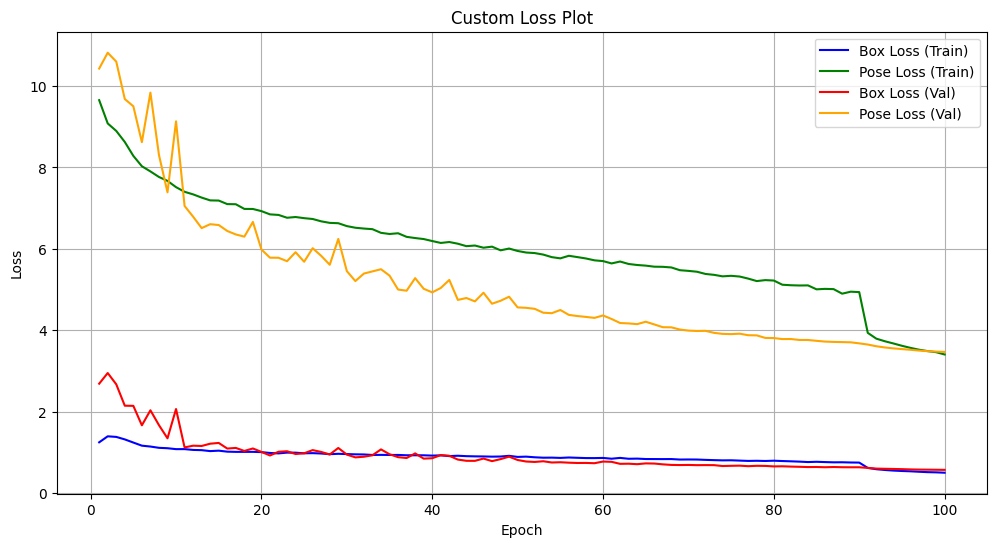

In [22]:
plot_training_validation_loss(data, title="Custom Loss Plot")

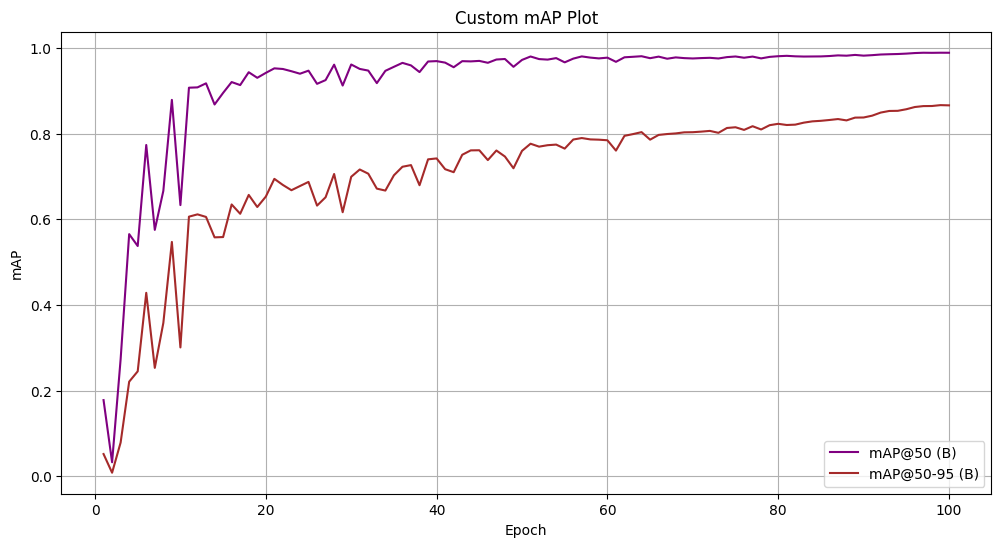

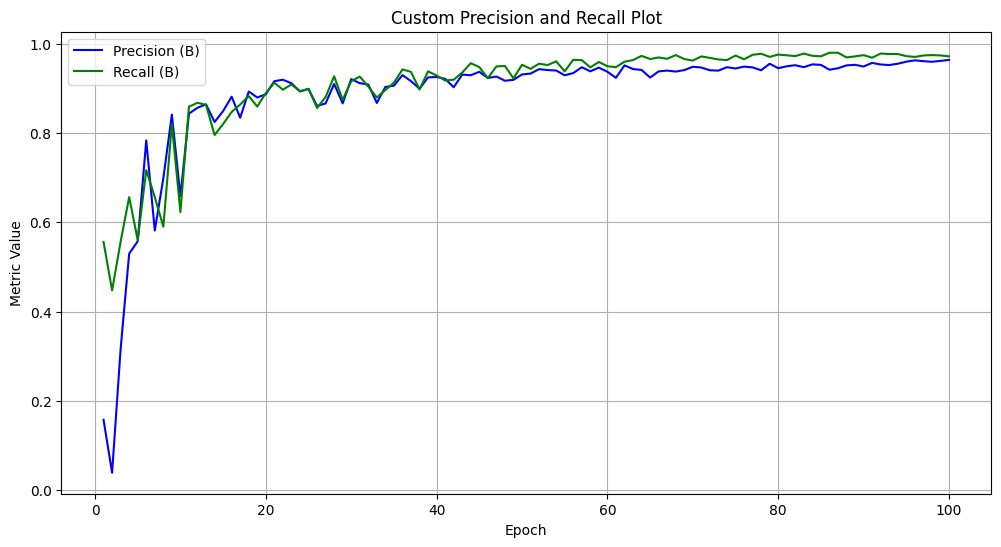

In [23]:
plot_map_metrics(data, title="Custom mAP Plot")
plot_precision_recall(data, title="Custom Precision and Recall Plot")

##Descarga del modelo k

In [ ]:
# Ruta de la carpeta a comprimir
#train_folder_path = "./runs/pose/train3"

# Ruta donde guardar el archivo comprimido
#output_zip_path = "./train3_backup.zip"

# Comprimir la carpeta
#shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', train_folder_path)

#print(f"Copia de seguridad creada: {output_zip_path}")

##Inferencia de keypoints


0: 480x640 1 dog, 477.3ms
Speed: 16.1ms preprocess, 477.3ms inference, 28.9ms postprocess per image at shape (1, 3, 480, 640)


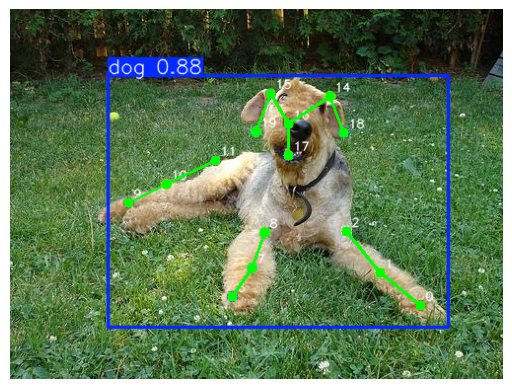

Keypoints detectados (x, y):
0: (x: 416.12, y: 300.41)
1: (x: 375.66, y: 267.40)
2: (x: 341.99, y: 225.38)
3: (x: 0.00, y: 0.00)
4: (x: 0.00, y: 0.00)
5: (x: 0.00, y: 0.00)
6: (x: 225.66, y: 291.22)
7: (x: 245.10, y: 262.54)
8: (x: 258.45, y: 226.92)
9: (x: 120.16, y: 196.76)
10: (x: 158.07, y: 177.13)
11: (x: 208.38, y: 153.29)
12: (x: 0.00, y: 0.00)
13: (x: 0.00, y: 0.00)
14: (x: 324.03, y: 88.83)
15: (x: 264.42, y: 85.21)
16: (x: 282.20, y: 116.42)
17: (x: 282.08, y: 148.68)
18: (x: 338.37, y: 125.24)
19: (x: 249.35, y: 124.28)
20: (x: 0.00, y: 0.00)
21: (x: 0.00, y: 0.00)
22: (x: 0.00, y: 0.00)
23: (x: 0.00, y: 0.00)


In [24]:
predict_random_image(model_best,"./datasets/dog-pose/train/images")

Nota: se observa que para todas las muestras los keypoints del 20 al 23 tienen coordenadas nulas, por lo que se decide eliminarlas.

##Etiquetado de clases de pose

Imágenes etiquetadas: 882 / 6773

0: 640x480 1 dog, 196.0ms
Speed: 4.4ms preprocess, 196.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


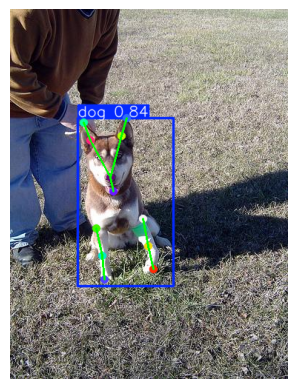

RadioButtons(description='Etiqueta:', options=('Parado', 'Sentado', 'Tumbado', 'Otro'), value='Parado')

Button(description='Guardar Etiqueta', style=ButtonStyle())

In [ ]:
# Ruta del dataset
images_path = "./datasets/dog-pose/train/images"

# Cargar etiquetas existentes, si las hay
output_labels = {}
if os.path.exists('labels5.json'):
    with open('labels5.json', 'r') as f:
        output_labels = json.load(f)

# Crear una lista de imágenes
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

# Obtener el índice inicial basado en imágenes etiquetadas
current_index = len(output_labels)

# Obtener el índice inicial basado en imágenes ya etiquetadas
labeled_images = set(output_labels.keys())  # Imágenes ya etiquetadas
current_index = 0
for i, img_name in enumerate(image_files):
    if img_name not in labeled_images:
        current_index = i
        break

# Iniciar etiquetado desde el índice actual
#label_current_image()
label_current_image_with_keypoints(model_best,images_path)

In [ ]:
# Guardar etiquetas en un archivo JSON
with open("labels5.json", "w") as f:
    json.dump(output_labels, f)

# Imprimir el largo del JSON (cantidad de elementos)
print("Etiquetas guardadas en labels5.json")
print(f"Largo del JSON: {len(output_labels)}")

# Contar la frecuencia de cada clase directamente sobre output_labels
class_counts = Counter(output_labels.values())

# Imprimir el conteo de valores por clase
print("Conteo de valores por clase:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

Etiquetas guardadas en labels5.json
Largo del JSON: 882
Conteo de valores por clase:
Tumbado: 86
Parado: 339
Otro: 335
Sentado: 122


##Armado del dataset para entrenamiento de pose

In [25]:
labels_file = 'labels5.json'
# Cargar etiquetas desde el archivo JSON
if os.path.exists(labels_file):
    with open(labels_file, 'r') as f:
        labels_data = json.load(f)
else:
    raise FileNotFoundError(f"El archivo {labels_file} no existe.")

In [26]:
# # Lista de índices de keypoints que deseas usar
# keypoints_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# keypoints_to_labels_with_balance(
#     model=model_best,
#     images_path="./datasets/dog-pose/train/images",
#     labels_data=labels_data,
#     output_file="keypoints_labels.npy",
#     balance_option=2,
#     keypoints_list=keypoints_list
# )


0: 480x640 1 dog, 294.2ms
Speed: 7.9ms preprocess, 294.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 285.7ms
Speed: 3.5ms preprocess, 285.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Etiqueta 'Otro' no válida para la imagen n02110185_5624.jpg. Omitiendo.

0: 640x544 1 dog, 330.7ms
Speed: 4.4ms preprocess, 330.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 576x640 1 dog, 346.7ms
Speed: 4.0ms preprocess, 346.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)
Etiqueta 'Otro' no válida para la imagen n02086079_1020.jpg. Omitiendo.

0: 480x640 1 dog, 263.5ms
Speed: 3.8ms preprocess, 263.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 358.8ms
Speed: 3.8ms preprocess, 358.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 273.2ms
Speed: 5.9ms preprocess, 273.2ms inference, 1.6ms postprocess per image at shap

In [62]:
# Cargar los datos del archivo .npy
dataset = np.load('keypoints_labels.npy', allow_pickle=True)

# Extraer las etiquetas (segundo elemento de cada fila)
labels = [row[1] for row in dataset]

# Contar la frecuencia de cada clase
class_counts = Counter(labels)

# Mostrar el conteo
print("Conteo de datos por clase:")
for label, count in class_counts.items():
    print(f"Clase {label}: {count}")

Conteo de datos por clase:
Clase 0: 339
Clase 1: 339
Clase 2: 339


##Entrenamiento del modelo p

In [65]:
# Separar las coordenadas x, y y aplanarlas
coordinates = np.array([np.array(row[2]).flatten() for row in dataset])
labels = np.array([row[1] for row in dataset])

# Preprocesar los datos, se convierten las etiquetas en una matriz de one-hot
X = coordinates
y = to_categorical(labels, num_classes=3)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en train y test de manera balanceada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1
)

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en los datos de validación
    patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True,  # Restaura los pesos del modelo en la mejor época
    verbose=1            # Muestra información en consola
)

Modelo guardado en 'model_p.h5'.
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - f1_score: 0.3208 - loss: 1.8810 - val_f1_score: 0.0981 - val_loss: 0.9975
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.4271 - loss: 1.5411 - val_f1_score: 0.2071 - val_loss: 0.9404
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.4979 - loss: 1.3216 - val_f1_score: 0.3013 - val_loss: 0.8950
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.4925 - loss: 1.3041 - val_f1_score: 0.4269 - val_loss: 0.8621
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.5378 - loss: 1.1334 - val_f1_score: 0.4703 - val_loss: 0.8364
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.5544 - loss: 1.1135 - val_f1_score: 0.5543 - val_loss: 0.8152
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.5645 - loss: 1.1314 - val_f1_score: 0.5834 - val_loss: 0.7892
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.6052 - loss: 0.9803 - val_f1_score: 0.6177 - val_loss: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.8816 - loss: 0.3023 
F1-score en datos de prueba: 0.89
Scaler exportado a scaler.pkl


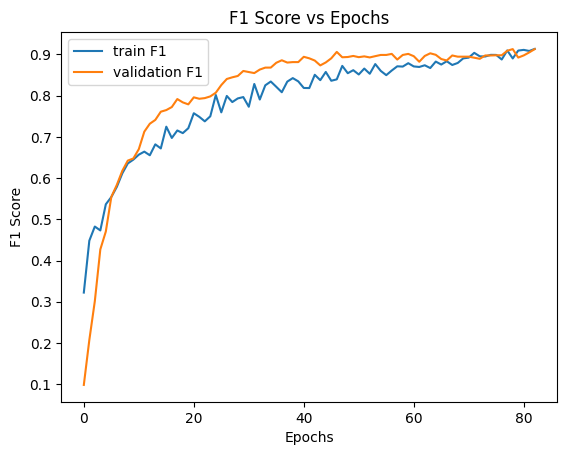

In [66]:
# Definir el modelo
model_p = Sequential([
    Dense(256, activation='relu', input_shape=(2*len(keypoints_list),)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar el modelo con F1 como métrica
model_p.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

# Entrenar el modelo con los datos de entrenamiento, separando un 20% de ellos para validación
history_p = model_p.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Guardar el modelo en un archivo .h5
model_p.save('model_p.h5')
print("Modelo guardado en 'model_p.h5'.")

# Evaluar el modelo
test_loss, test_f1 = model_p.evaluate(X_test, y_test)
print(f"F1-score en datos de prueba: {test_f1:.2f}")

# Guardar el scaler en un archivo
joblib.dump(scaler, "scaler.pkl")
print("Scaler exportado a scaler.pkl")

# Imprimir gráfico con valores de F1 durante el entrenamiento
plt.title('F1 Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.plot(history_p.history['f1_score'], label='train F1')
plt.plot(history_p.history['val_f1_score'], label='validation F1')
plt.legend()
plt.show()

##Matriz de confusión del modelo p

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


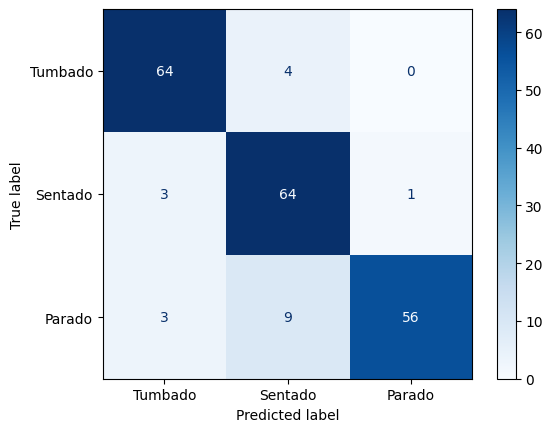

In [67]:
# Cargar el modelo
model_p = load_model("model_p.h5")

# Predicciones y etiquetas verdaderas
y_pred = model_p.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Definir las etiquetas de las clases
class_labels = ["Tumbado", "Sentado", "Parado"]

# Mostrar la matriz de confusión con etiquetas personalizadas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")  # Puedes cambiar el colormap si lo deseas

##Reducción de keypoints para entrenamiento de pose

In [33]:
lesskeypoints_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

# keypoints_to_labels_with_balance(
#     model=model_best,
#     images_path="./datasets/dog-pose/train/images",
#     labels_data=labels_data,
#     output_file="lesskeypoints_labels.npy",
#     balance_option=2,
#     keypoints_list=lesskeypoints_list
# )


0: 480x640 1 dog, 184.9ms
Speed: 6.2ms preprocess, 184.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 152.9ms
Speed: 4.0ms preprocess, 152.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Etiqueta 'Otro' no válida para la imagen n02110185_5624.jpg. Omitiendo.

0: 640x544 1 dog, 189.2ms
Speed: 4.2ms preprocess, 189.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 576x640 1 dog, 191.6ms
Speed: 4.7ms preprocess, 191.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
Etiqueta 'Otro' no válida para la imagen n02086079_1020.jpg. Omitiendo.

0: 480x640 1 dog, 177.2ms
Speed: 4.0ms preprocess, 177.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 172.8ms
Speed: 4.3ms preprocess, 172.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 160.6ms
Speed: 3.6ms preprocess, 160.6ms inference, 1.1ms postprocess per image at shap

In [70]:
# Cargar los datos del archivo .npy
dataset = np.load('lesskeypoints_labels.npy', allow_pickle=True)

# Extraer las etiquetas (segundo elemento de cada fila)
labels = [row[1] for row in dataset]

# Contar la frecuencia de cada clase
class_counts = Counter(labels)

# Mostrar el conteo
print("Conteo de datos por clase:")
for label, count in class_counts.items():
    print(f"Clase {label}: {count}")

Conteo de datos por clase:
Clase 0: 339
Clase 1: 339
Clase 2: 339


##Entrenamiento del modelo p con lesskeypoints_list

In [71]:
# Separar las coordenadas x, y y aplanarlas
coordinates = np.array([np.array(row[2]).flatten() for row in dataset])
labels = np.array([row[1] for row in dataset])

# Preprocesar los datos, se convierten las etiquetas en una matriz de one-hot
X = coordinates
y = to_categorical(labels, num_classes=3)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en train y test de manera balanceada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en los datos de validación
    patience=10,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True,  # Restaura los pesos del modelo en la mejor época
    verbose=1            # Muestra información en consola
)

Modelo guardado en 'model_p.h5'.
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - f1_score: 0.3267 - loss: 1.8924 - val_f1_score: 0.0460 - val_loss: 0.9919
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.4451 - loss: 1.5737 - val_f1_score: 0.2703 - val_loss: 0.9256
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.4828 - loss: 1.4692 - val_f1_score: 0.4029 - val_loss: 0.8858
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5379 - loss: 1.2193 - val_f1_score: 0.4245 - val_loss: 0.8568
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.5861 - loss: 1.1720 - val_f1_score: 0.4519 - val_loss: 0.8277
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.5324 - loss: 1.1588 - val_f1_score: 0.5127 - val_loss: 0.8006
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score: 0.5800 - loss: 1.0596 - val_f1_score: 0.5109 - val_loss: 0.7836
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.6295 - loss: 0.9610 - val_f1_score: 0.5493 - val_loss: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9295 - loss: 0.2463 
F1-score en datos de prueba: 0.92
Scaler exportado a scaler.pkl


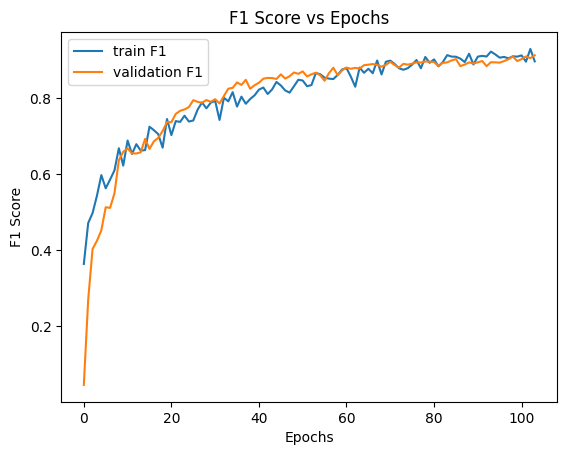

In [72]:
# Definir el modelo
model_pless = Sequential([
    Dense(256, activation='relu', input_shape=(2*len(lesskeypoints_list),)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar el modelo con F1 como métrica
model_pless.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

print("Modelo guardado en 'model_p.h5'.")

# Entrenar el modelo con los datos de entrenamiento, separando un 20% de ellos para validación
history_pless = model_pless.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Guardar el modelo en un archivo .h5
model_pless.save('model_pless.h5')

# Evaluar el modelo
test_loss, test_f1 = model.evaluate(X_test, y_test)
print(f"F1-score en datos de prueba: {test_f1:.2f}")

# Guardar el scaler en un archivo
joblib.dump(scaler, "scaler.pkl")
print("Scaler exportado a scaler.pkl")

# Imprimir gráfico con valores de F1 durante el entrenamiento
plt.title('F1 Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.plot(history_pless.history['f1_score'], label='train F1')
plt.plot(history_pless.history['val_f1_score'], label='validation F1')
plt.legend()
plt.show()

##Matriz de confusión del modelo p con lesskeypoints

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


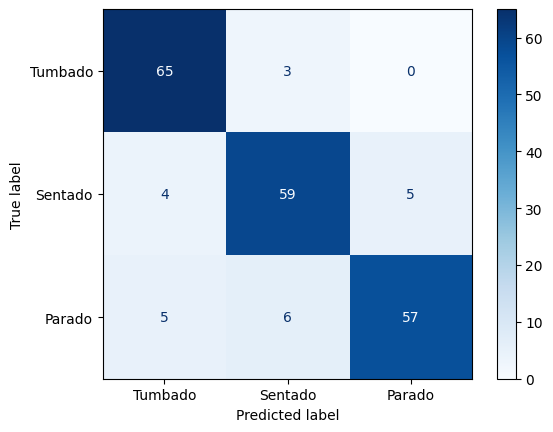

In [73]:
# Cargar el modelo
model_pless = load_model("model_pless.h5")

# Predicciones y etiquetas verdaderas
y_pred = model_pless.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Definir las etiquetas de las clases
class_labels = ["Tumbado", "Sentado", "Parado"]

# Mostrar la matriz de confusión con etiquetas personalizadas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")  # Puedes cambiar el colormap si lo deseas

##Inferencia de pose


0: 544x640 1 dog, 317.0ms
Speed: 4.8ms preprocess, 317.0ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


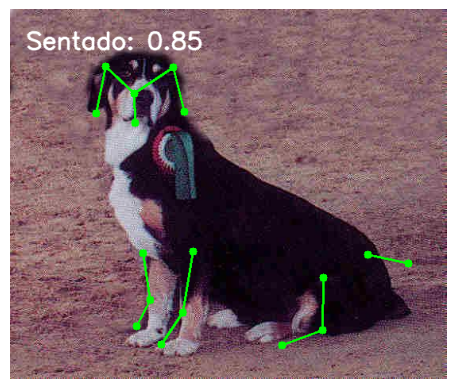

Clase predicha: Sentado
Probabilidades: [  0.0015235     0.85163     0.14685]
Clase predicha: Sentado


In [131]:
image_path="./datasets/dog-pose/val/images"

coordinates_example, predicted_class_label = predict_pose(model_best, model_pless, scaler, image_path,lesskeypoints_list)
print("Clase predicha:", predicted_class_label)

##Reetiquetado de clases

In [ ]:
# json_path = "labels5.json"
# images_path = "./datasets/dog-pose/train/images"
# target_class = "Sentado"
# relabel_image_with_keypoints(target_class, json_path, images_path, model_best)

¡Todas las imágenes de la clase seleccionada han sido etiquetadas!
Total de imágenes etiquetadas: 791


In [ ]:
# # Guardar etiquetas en un archivo JSON
# with open("labels5.json", "w") as f:
#     json.dump(output_labels, f)

# # Imprimir el largo del JSON (cantidad de elementos)
# print("Etiquetas guardadas en labels5.json")
# print(f"Largo del JSON: {len(output_labels)}")

# # Contar la frecuencia de cada clase directamente sobre output_labels
# class_counts = Counter(output_labels.values())

# # Imprimir el conteo de valores por clase
# print("Conteo de valores por clase:")
# for label, count in class_counts.items():
#     print(f"{label}: {count}")

Etiquetas guardadas en labels4.json
Largo del JSON: 791
Conteo de valores por clase:
Tumbado: 73
Parado: 310
Otro: 301
Sentado: 107


##Entrenamiento del modelo p_resnet

In [152]:
# Redimensionar los datos para adaptarlos al formato de ResNet
# ResNet espera entradas de forma (altura, ancho, canales)
X_train_resnet = X_train.reshape((-1, 2, 17, 1))  # Ejemplo de reshape, ajustar según tus datos
X_test_resnet = X_test.reshape((-1, 2, 17, 1))

# Redimensionar para que tenga 3 canales (RGB), necesario para ResNet preentrenada
X_train_resnet = np.repeat(X_train_resnet, 3, axis=-1)
X_test_resnet = np.repeat(X_test_resnet, 3, axis=-1)

# Redimensionar los datos
X_train_resnet = np.array([resize(x, (32, 32)).numpy() for x in X_train_resnet])
X_test_resnet = np.array([resize(x, (32, 32)).numpy() for x in X_test_resnet])

# Configurar modelo ResNet50 preentrenado
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Congelar los pesos del backbone
for layer in resnet_base.layers:
    layer.trainable = False

x = Flatten()(resnet_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_p_resnet = Model(inputs=resnet_base.input, outputs=x)

# Compilar el modelo
model_p_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=[f1_score])

In [153]:
# Entrenar el modelo
history_resnet = model_p_resnet.fit(
    X_train_resnet, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 514ms/step - f1_score: 0.3424 - loss: 1.5771 - val_f1_score: 0.2929 - val_loss: 1.0443
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - f1_score: 0.3565 - loss: 1.1531 - val_f1_score: 0.1365 - val_loss: 1.0051
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - f1_score: 0.3080 - loss: 1.0056 - val_f1_score: 0.2632 - val_loss: 0.9683
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - f1_score: 0.3378 - loss: 0.9426 - val_f1_score: 0.2902 - val_loss: 0.9328
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - f1_score: 0.4148 - loss: 0.9293 - val_f1_score: 0.3366 - val_loss: 0.9139
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - f1_score: 0.4659 - loss: 0.9079 - val_f1_score: 0.4568 - val_loss: 0.8977
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - f1_score: 0.4815 - loss: 0.8961 - val_f1_score: 0.4798 - val_loss: 0.8763
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - f1_score: 0.4975 - loss: 0.8762 - val_f1_

In [154]:
# Guardar el modelo
model_p_resnet.save('model_resnet.h5')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - f1_score: 0.3236 - loss: 0.9894
F1-score en datos de prueba: 0.37


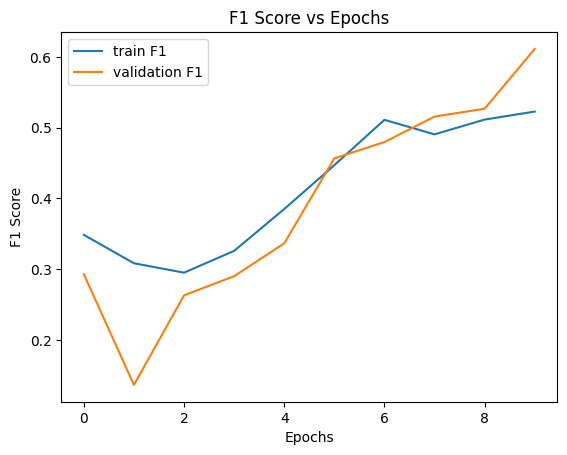

In [155]:
# Evaluar el modelo
test_loss, test_f1 = model_p_resnet.evaluate(X_test_resnet, y_test)
print(f"F1-score en datos de prueba: {test_f1:.2f}")

# Gráfico de entrenamiento
plt.title('F1 Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.plot(history_resnet.history['f1_score'], label='train F1')
plt.plot(history_resnet.history['val_f1_score'], label='validation F1')
plt.legend()
plt.show()

##Inferencia de pose con p_resnet

In [ ]:
def predict_pose_resnet(model_k, model_p_resnet, scaler, images_path):
    """
    Predice la pose a partir de keypoints utilizando YOLO y ResNet.
    """
    import os
    import random
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Verificar si la ruta existe
    if not os.path.exists(images_path):
        raise FileNotFoundError(f"La ruta especificada no existe: {images_path}")

    # Listar todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    # Verificar si hay imágenes en la carpeta
    if not image_files:
        raise FileNotFoundError(f"No se encontraron imágenes en la ruta: {images_path}")

    # Seleccionar una imagen aleatoria
    random_image = random.choice(image_files)
    random_image_path = os.path.join(images_path, random_image)

    # Cargar la imagen seleccionada
    image = cv2.imread(random_image_path)
    image_no_text = image.copy()

    # Realizar la predicción de keypoints
    results = model_k(image)

    # Obtener keypoints de la predicción
    coordinates_example = []
    if hasattr(results[0], "keypoints") and results[0].keypoints is not None:
        keypoints_data = results[0].keypoints.data.cpu().numpy()  # Convertir a numpy array
        for row in keypoints_data[0]:  # Suponiendo que es un array 3D [1, N, 3]
            coordinates_example.append((float(row[0]), float(row[1])))
    else:
        print("No se encontraron keypoints en los resultados.")
        coordinates_example = [(0.00, 0.00)] * 24

    # Dibujar los keypoints y las conexiones en la imagen
    pairs_to_connect = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9),
                        (10, 11), (11, 12), (13, 14), (15, 19), (15, 17),
                        (16, 17), (17, 18), (16, 20)]

    for i, (x, y) in enumerate(coordinates_example):
        if (x, y) != (0.00, 0.00):  # Dibujar solo keypoints válidos
            cv2.circle(image_no_text, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)

    for pair in pairs_to_connect:
        idx1, idx2 = pair
        if idx1 <= len(coordinates_example) and idx2 <= len(coordinates_example):
            x1, y1 = coordinates_example[idx1 - 1]
            x2, y2 = coordinates_example[idx2 - 1]
            if (x1, y1) != (0.00, 0.00) and (x2, y2) != (0.00, 0.00):
                pt1 = (int(x1), int(y1))
                pt2 = (int(x2), int(y2))
                cv2.line(image_no_text, pt1, pt2, color=(0, 255, 0), thickness=2)

    # Normalizar y transformar las coordenadas para ResNet
    input_data = np.array(coordinates_example).flatten().reshape(1, -1)
    input_data_normalized = scaler.transform(input_data)

    # Cambiar la forma de las coordenadas a formato compatible con ResNet
    input_data_resnet = input_data_normalized.reshape(-1, 6, 8, 1)  # Dimensiones originales
    input_data_resnet = np.repeat(input_data_resnet, 3, axis=-1)  # Convertir a RGB

    # Redimensionar las entradas a 32x32
    input_data_resnet_resized = np.array([resize(img, (32, 32)).numpy() for img in input_data_resnet])

    # Realizar la predicción de la pose
    class_labels = ["Tumbado", "Sentado", "Parado"]  # Etiquetas de las clases
    probabilities = model_p_resnet.predict(input_data_resnet_resized)
    predicted_class_index = np.argmax(probabilities)
    predicted_class_label = class_labels[predicted_class_index]

    # Mostrar la etiqueta sobre la imagen
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"{predicted_class_label}"
    text_position = (20, 50)  # Posición del texto
    cv2.putText(image_no_text, text, text_position, font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Mostrar la imagen anotada con la etiqueta
    plt.imshow(cv2.cvtColor(image_no_text, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Imprimir las probabilidades
    print(f"Clase predicha: {predicted_class_label}")
    print(f"Probabilidades: {probabilities[0]}")

    return coordinates_example, predicted_class_label


In [ ]:
# Ruta del archivo zip
zip_path = "./test.zip"
output_dir = "./test_images"

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Archivos descomprimidos en: {output_dir}")

Archivos descomprimidos en: ./test_images



0: 480x640 1 dog, 176.6ms
Speed: 3.5ms preprocess, 176.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


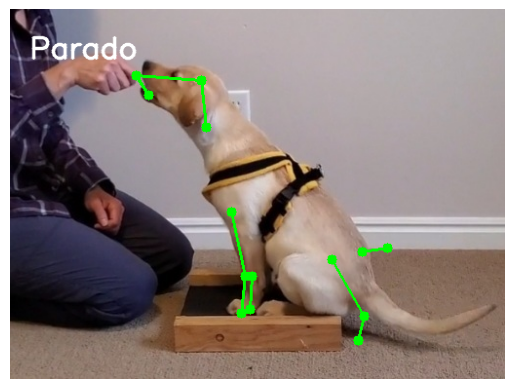

Clase predicha: Parado
Probabilidades: [ 4.1924e-07  1.8935e-06           1]
Clase predicha: Parado


In [ ]:
# image_path="./datasets/dog-pose/train/images"
image_path="./test_images/test/sentado"

coordinates_example, predicted_class_label = predict_pose_resnet(model_best, model_p_resnet, scaler, image_path)
print("Clase predicha:", predicted_class_label)

##Inferencia de pose en tiempo real